In [9]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import matplotlib.pyplot as plt
import cv2
from skimage.transform import rescale, resize, downscale_local_mean
import torchvision
import torch
import torch.nn as nn
import pandas as pd
import requests
import torchxrayvision as xrv
from PIL import ImageOps,Image
from load_models import load_bin_model


torch.Size([1, 1, 224, 224])
(224, 224, 3)


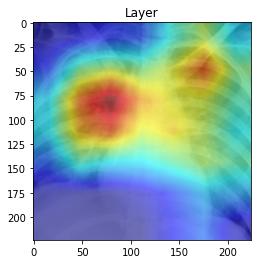

In [16]:
typedevice = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(typedevice)
def definemodel(use_summary = True,weights = "densenet121-res224-mimic_nb"):
        '''
        Definition of the model
        '''
        ## Load the mdodel
        model = xrv.models.DenseNet(weights=weights)
        ### Moodifications of the model
        model.op_threshs = None # prevent pre-trained model calibration
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential( nn.Linear(in_features=1024, out_features=2),torch.nn.LogSoftmax(dim=1)) #  Change the linear layer since 18 outputs to 2 
        model = model.to(device)
        return model

ckpoints = ['densenet121-res224-all','densenet121-res224-rsna','densenet121-res224-nih','densenet121-res224-pc','densenet121-res224-chex','densenet121-res224-mimic_ch']
model = definemodel(weights=ckpoints[0])

path_model = ckpoints[0].split('-')[-1]
base_name = f'../models/checkpoints/{path_model}.pt'
model.load_state_dict(torch.load(base_name,map_location=torch.device(typedevice)))

index = 1
image = ImageOps.grayscale(Image.open('./pneumonia/patient38925_000.jpg'))
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(224),
            torchvision.transforms.CenterCrop(224) ,
            torchvision.transforms.ToTensor()])
image_resize = transforms(image)

input_tensor = image_resize[None,...].type(torch.FloatTensor) 
# # # Note: input_tensor can be a batch tensor with several images!
print(input_tensor.shape)


target_layers = [model.features.denseblock4[i] for i in range(len(model.features.denseblock4))]
# # Construct the CAM object once, and then re-use it on many images:
cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=False)

# # You can also use it within a with statement, to make sure it is freed,
# # In case you need to re-create it inside an outer loop:
# # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
# #   ...

# # We have to specify the target we want to generate
# # the Class Activation Maps for.
# # If targets is None, the highest scoring category
# # will be used for every image in the batch.
# # Here we use ClassifierOutputTarget, but you can define your own custom targets
# # That are, for example, combinations of categories, or specific outputs in a non standard model.
targets = [ClassifierOutputTarget(index)]

# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
img_vis = image_resize[0,:,:][...,None].numpy().repeat(3,-1)
print(img_vis.shape)
visualization = show_cam_on_image(img_vis, grayscale_cam, use_rgb=True)
# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
plt.title(f'Layer')
plt.imshow(visualization,cmap = 'bone')




In [30]:
image_resize

torch.Size([1, 224, 224])

In [ ]:
for model_cam in ['GradCAM','GradCAMPlusPlus','XGradCAM', 'EigenCAM', 'FullGrad']:
            fig,axs = plt.subplots(2,2,figsize = (10,10))
            axs = axs.ravel()
            fig.suptitle(model_cam+' model', fontsize=16)
            for i,(modeltype) in enumerate([f'model.layer{i}' for i in range(1,5)]):
                model = resnet50(pretrained=True)
                target_layers = [eval(modeltype)[-1]]
                input_tensor = totensor(img_resize)[None,...].type(torch.FloatTensor) 
                # # Note: input_tensor can be a batch tensor with several images!

                # # Construct the CAM object once, and then re-use it on many images:
                cam = eval(model_cam)(model=model, target_layers=target_layers, use_cuda=False)

                # # You can also use it within a with statement, to make sure it is freed,
                # # In case you need to re-create it inside an outer loop:
                # # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
                # #   ...

                # # We have to specify the target we want to generate
                # # the Class Activation Maps for.
                # # If targets is None, the highest scoring category
                # # will be used for every image in the batch.
                # # Here we use ClassifierOutputTarget, but you can define your own custom targets
                # # That are, for example, combinations of categories, or specific outputs in a non standard model.
                targets = [ClassifierOutputTarget(index)]

                # # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
                grayscale_cam = grayscale_cam[0, :]
                visualization = show_cam_on_image(img_resize, grayscale_cam, use_rgb=True)
                # # In this example grayscale_cam has only one image in the batch:
                # grayscale_cam = grayscale_cam[0, :]
                # visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
                axs[i].set_title(f'Layer {i+1}')
                axs[i].imshow(visualization,cmap = 'bone')
            fig.show()
            plt.show()